## Simulated Data

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_units = 10           # 10 units
n_periods = 20        # 20 times
treated_ids = [6, 7, 8, 9, 10]
post_start_time = 15   # treated starting from time 15

unit_effects = {i: np.random.uniform(5, 15) for i in range(1, n_units + 1)}
time_trends = {t: np.sin(t / 2) + (t * 0.1) for t in range(1, n_periods + 1)}

beta_1, beta_2 = 1.5, -0.8

rows = []
for unit in range(1, n_units + 1):
    for time in range(1, n_periods + 1):

        is_treated_unit = unit in treated_ids
        is_post_period = time >= post_start_time
        treated = 1 if (is_treated_unit and is_post_period) else 0
        
        cov_1 = np.random.normal(loc=unit*0.1, scale=1) 
        cov_2 = np.random.uniform(0, 5)               
        
        # constructing outcome: Y = FE_unit + FE_time + X*Beta + ATT*D + Noise)
        # assume that ATT = 5
        att = 5 if treated == 1 else 0
        noise = np.random.normal(0, 0.5)
        
        outcome = (unit_effects[unit] + 
                   time_trends[time] + 
                   cov_1 * beta_1 + 
                   cov_2 * beta_2 + 
                   att + 
                   noise)
        
        rows.append([unit, time, treated, outcome, cov_1, cov_2])

data = pd.DataFrame(rows, columns=["unit", "time", "treated", "outcome", "x1", "x2"])

print(f"shape: {data.shape}")
print(f"treated units: {treated_ids}")
print(f"post treatment terms: {list(range(post_start_time, n_periods + 1))}")
print(data.head())

shape: (200, 6)
treated units: [6, 7, 8, 9, 10]
post treatment terms: [15, 16, 17, 18, 19, 20]
   unit  time  treated    outcome        x1        x2
0     1     1        0   8.314595 -0.369474  0.909125
1     1     2        0   6.518735 -0.471380  2.623782
2     1     3        0   4.876964 -1.624918  3.059264
3     1     4        0   7.725979 -0.328046  1.831809
4     1     5        0  11.280763  1.565649  0.998369


In [2]:
from sdid import SyntheticDID

# sdid with covariates
model0 = SyntheticDID(omega_type="parallel")
model0.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

# sdid without covariates
model1 = SyntheticDID(omega_type="parallel")
model1.fit(data, 'outcome', 'unit', 'time', 'treated')

# sc with covariates
model2 = SyntheticDID(omega_type="match")
model2.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

# did with covariates
model3 = SyntheticDID(zeta_omega="inf", zeta_lambda="inf")
model3.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

/Users/ollie/anaconda3/envs/sdid_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


estimated ATT = 4.796178076010272


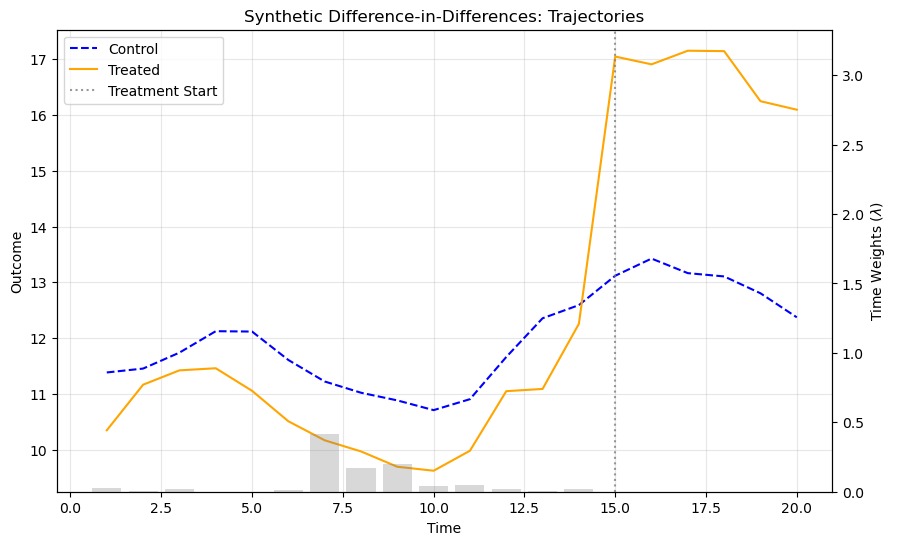

In [3]:
print(f"estimated ATT = {model0.ATT_diff}")
model0.plot_trajectories()

estimated ATT = 5.427050560234464


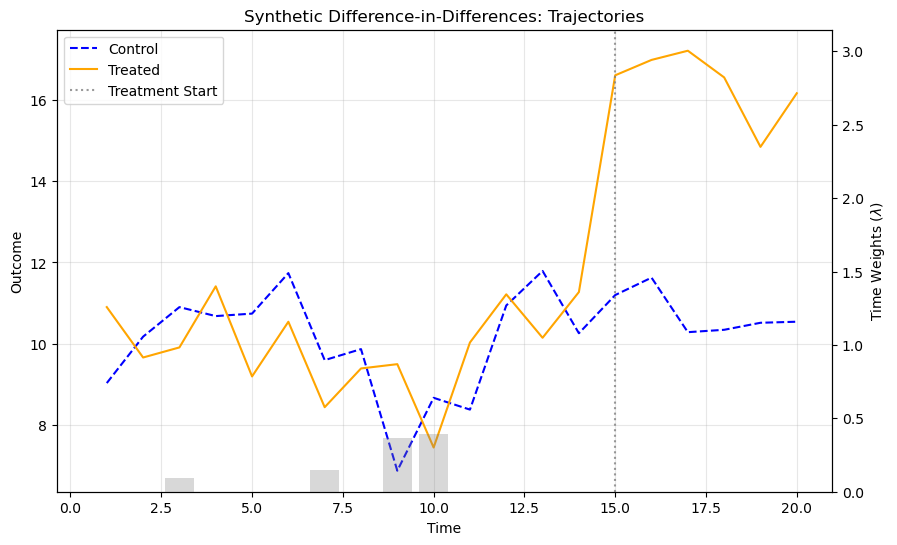

In [4]:
print(f"estimated ATT = {model1.ATT_diff}")
model1.plot_trajectories()

estimated ATT = 4.7961673443027415


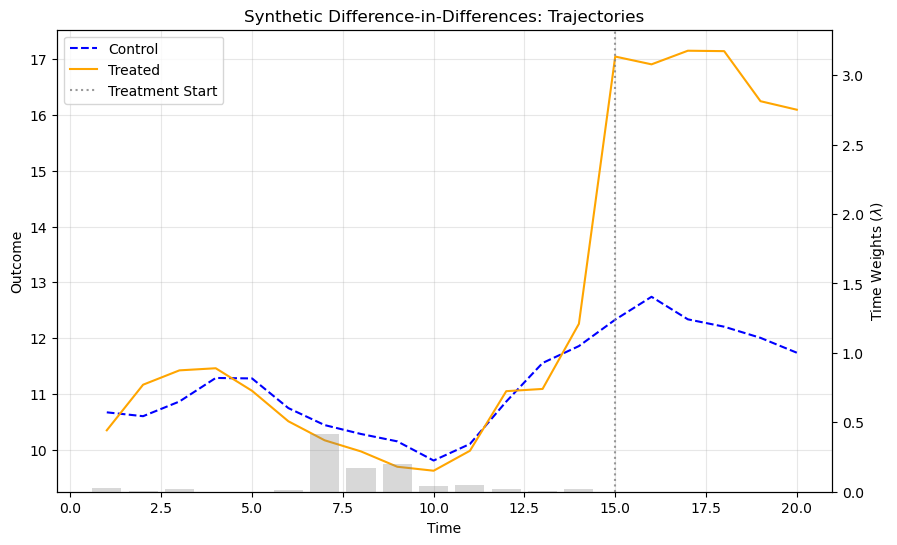

In [5]:
print(f"estimated ATT = {model2.ATT_diff}")
model2.plot_trajectories()

estimated ATT = 4.614953625764918


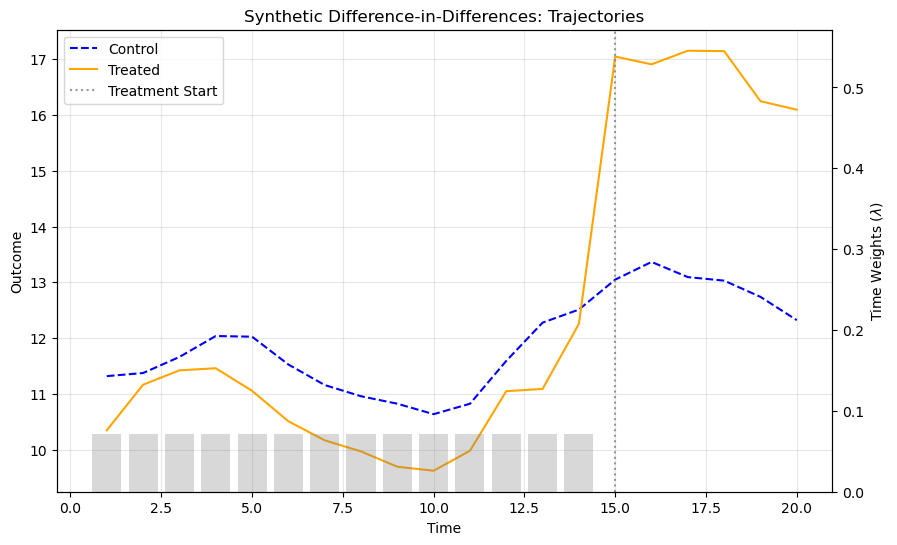

In [6]:
print(f"estimated ATT = {model3.ATT_diff}")
model3.plot_trajectories()

## Real Data

In [7]:
import pandas as pd

dt = pd.read_csv("https://github.com/d2cml-ai/Synthdid.jl/raw/stag_treat/data/california_prop99.csv", sep=";")

dt.head()

,State,Year,PacksPerCapita,treated
0,Alabama,1970,89.800003,0
1,Arkansas,1970,100.300003,0
2,Colorado,1970,124.800003,0
3,Connecticut,1970,120.000000,0
4,Delaware,1970,155.000000,0


In [8]:
from sdid import SyntheticDID

# sdid
model1 = SyntheticDID()
model1.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

# sc
model2 = SyntheticDID(omega_type="match")
model2.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

# sc with negative weights
model3 = SyntheticDID(omega_type="match", negative_omega=True)
model3.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

# sdid with sparse estimation for omegas
model4 = SyntheticDID(sparse_threshold=0.1, zeta_omega=0)
model4.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

-12.593275741919133
-15.60377621195305


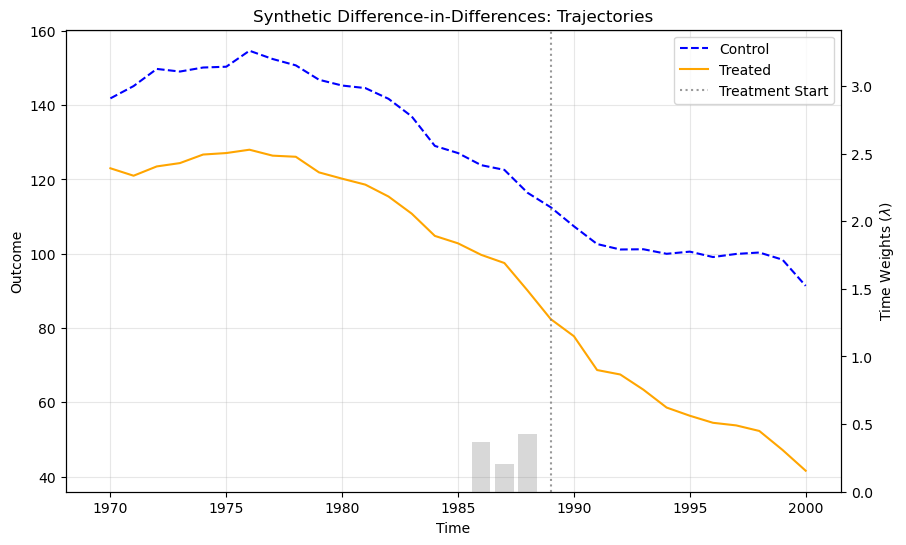

In [9]:
print(model1.ATT)
print(model1.ATT_diff)
model1.plot_trajectories()

-14.975861885341972
-18.74768008582058


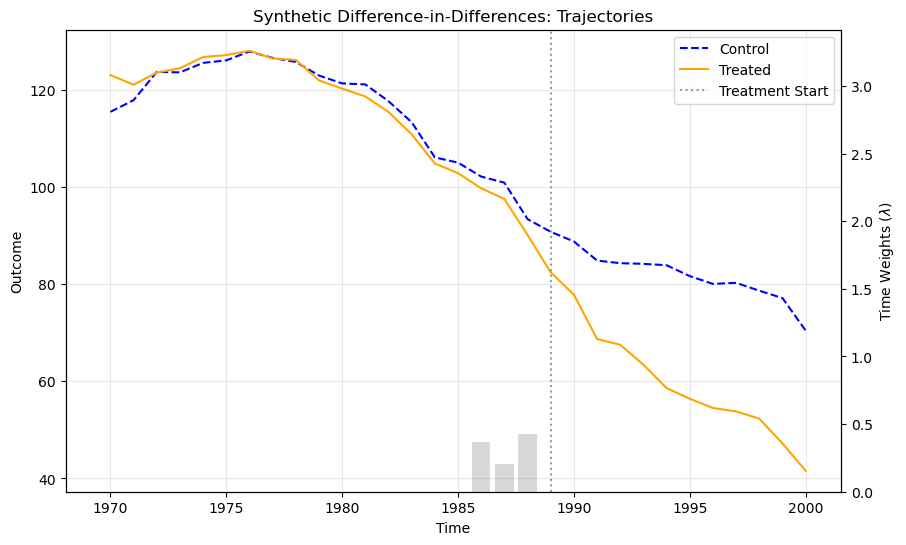

In [10]:
print(model2.ATT)
print(model2.ATT_diff)
model2.plot_trajectories()

-15.626371738877308
-17.62500173549338


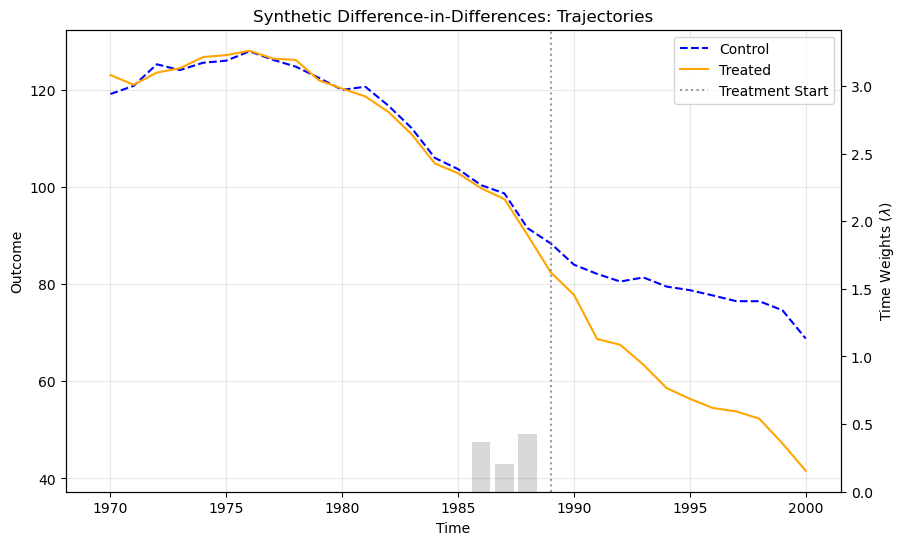

In [11]:
print(model3.ATT)
print(model3.ATT_diff)
model3.plot_trajectories()

-9.198771918109523
-10.668602728023654


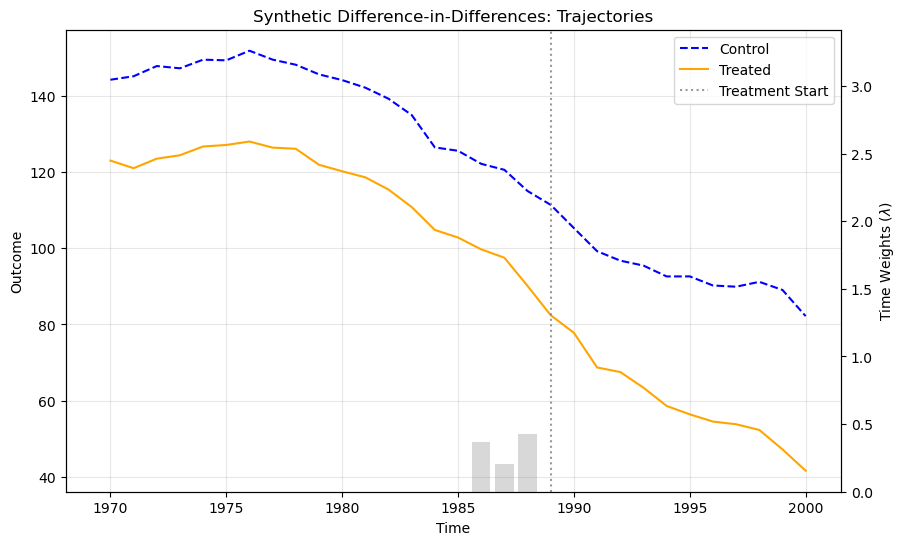

[-2.31857620e+01  0.00000000e+00  0.00000000e+00  9.58749027e-02
  2.65969279e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.54085729e-01  0.00000000e+00  0.00000000e+00  1.37700068e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.09856632e-02  9.25980461e-02
  2.27641105e-01  5.87257022e-02  0.00000000e+00  1.03495654e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [12]:
print(model4.ATT)
print(model4.ATT_diff)
model4.plot_trajectories()
print(model4.omega)

## Inference

In [13]:
from sdid import SyntheticDID
import pandas as pd

dt = pd.read_csv("https://github.com/d2cml-ai/Synthdid.jl/raw/stag_treat/data/california_prop99.csv", sep=";")

dt.head()

,State,Year,PacksPerCapita,treated
0,Alabama,1970,89.800003,0
1,Arkansas,1970,100.300003,0
2,Colorado,1970,124.800003,0
3,Connecticut,1970,120.000000,0
4,Delaware,1970,155.000000,0


In [14]:
model = SyntheticDID().fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

In [15]:
model.infer(method="bootstrap", rep=50)

bootstrapping ...: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]

Synthetic Difference-in-Differences Estimations
-----------------------------------------------------------------
Parameter  |        Estimate |   Std. Error |    z-score |    p > |z|
-----------------------------------------------------------------
ATT        |     -12.5933*** |       2.4895 |     -5.059 | 4.2238e-07
           | [-17.473, -7.714] (95% CI)
ATT_diff   |     -15.6038*** |       2.6349 |     -5.922 | 3.1813e-09
           | [-20.768, -10.439] (95% CI)
-----------------------------------------------------------------
Significance codes:  *** p<0.01, ** p<0.05, * p<0.1


{'ATT': {'estimate': np.float64(-12.593275741919133),
  'Std.Err': np.float64(2.489487154756943),
  'ci_90': (np.float64(-16.68811771767019), np.float64(-8.498433766168075)),
  'ci_95': (np.float64(-17.472580905217832), np.float64(-7.713970578620433)),
  'z_value': np.float64(-5.058582334058541),
  'p_value': np.float64(4.223848713014178e-07)},
 'ATT_diff': {'estimate': np.float64(-15.60377621195305),
  'Std.Err': np.float64(2.634902017150206),
  'ci_90': (np.float64(-19.937804351524317), np.float64(-11.269748072381784)),
  'ci_95': (np.float64(-20.768089268359393), np.float64(-10.439463155546708)),
  'z_value': np.float64(-5.921956911638562),
  'p_value': np.float64(3.181329866208671e-09)}}

In [ ]:
model.infer(method="placebo", rep=50)

placeboing ...: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]

Synthetic Difference-in-Differences Estimations
-----------------------------------------------------------------
Parameter  |        Estimate |   Std. Error |    z-score |    p > |z|
-----------------------------------------------------------------
ATT        |     -12.5933**  |       5.8328 |     -2.159 | 3.0846e-02
           | [-24.025, -1.161] (95% CI)
ATT_diff   |     -15.6038*   |       8.7641 |     -1.780 | 7.5007e-02
           | [-32.781, 1.574] (95% CI)
-----------------------------------------------------------------
Significance codes:  *** p<0.01, ** p<0.05, * p<0.1


{'ATT': {'estimate': np.float64(-12.593275741919133),
  'Std.Err': np.float64(5.832778802033678),
  'ci_90': (np.float64(-22.187343109649888), np.float64(-2.9992083741883757)),
  'ci_95': (np.float64(-24.025312123693823), np.float64(-1.1612393601444424)),
  'z_value': np.float64(-2.1590525149913646),
  'p_value': np.float64(0.030846092996110963)},
 'ATT_diff': {'estimate': np.float64(-15.60377621195305),
  'Std.Err': np.float64(8.764078115141917),
  'ci_90': (np.float64(-30.019401886530254), np.float64(-1.188150537375849)),
  'ci_95': (np.float64(-32.78105367532689), np.float64(1.5735012514207867)),
  'z_value': np.float64(-1.7804241366806186),
  'p_value': np.float64(0.07500657457181537)}}